# Tensorflow.keras implementation of one-bit-per-weight CNN for CIFAR 10 
##  https://arxiv.org/abs/1907.06916
## Mark D. McDonnell, Hesham Mostafa, Runchun Wang, Andre van Schaik,
## Single-bit-per-weight deep convolutional neural networks without batch-normalization layers for embedded systems

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '8'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet_srelu
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
WhichDataSet = 'CIFAR10'
#WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 300
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=True
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')#/255.0
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
def catcross_entropy_logits_loss():
    def loss(y_true, y_pred):
        return tensorflow.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return loss

In [5]:
#define a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
Temperature=40.0
model = resnet_srelu(Temperature,UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,
                     wd=My_wd,width=resnet_width)
model.compile(loss=catcross_entropy_logits_loss() ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [],
                              Tmult=300.0) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
binary_conv2d (BinaryConv2D)    (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 160)  0           binary_conv2d[0][0]              
__________________________________________________________________________________________________
re_lu (ReL

In [6]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/300
10000/10000 [==============================] - 8s 786us/sample - loss: 3.9888 - acc: 0.4307

 End of Epoch Learning Rate = 0.099997
400/400 [==============================] - 121s 303ms/step - loss: 4.8895 - acc: 0.2614 - val_loss: 3.9888 - val_acc: 0.4307

 Start of Epoch Learning Rate = 0.099997
Epoch 2/300
10000/10000 [==============================] - 8s 759us/sample - loss: 3.1107 - acc: 0.5132

 End of Epoch Learning Rate = 0.099989
400/400 [==============================] - 118s 294ms/step - loss: 3.5624 - acc: 0.4488 - val_loss: 3.1107 - val_acc: 0.5132

 Start of Epoch Learning Rate = 0.099989
Epoch 3/300
10000/10000 [==============================] - 7s 750us/sample - loss: 2.2573 - acc: 0.6504

 End of Epoch Learning Rate = 0.099975
400/400 [==============================] - 117s 294ms/step - loss: 2.7182 - acc: 0.5582 - val_loss: 2.2573 - val_acc: 0.6504

 Start of Epoch Le

10000/10000 [==============================] - 7s 747us/sample - loss: 0.8085 - acc: 0.8752

 End of Epoch Learning Rate = 0.098158
400/400 [==============================] - 117s 293ms/step - loss: 0.8586 - acc: 0.8514 - val_loss: 0.8085 - val_acc: 0.8752

 Start of Epoch Learning Rate = 0.098158
Epoch 27/300
10000/10000 [==============================] - 7s 743us/sample - loss: 0.8123 - acc: 0.8726

 End of Epoch Learning Rate = 0.098015
400/400 [==============================] - 118s 294ms/step - loss: 0.8756 - acc: 0.8468 - val_loss: 0.8123 - val_acc: 0.8726

 Start of Epoch Learning Rate = 0.098015
Epoch 28/300
10000/10000 [==============================] - 7s 735us/sample - loss: 0.8017 - acc: 0.8765

 End of Epoch Learning Rate = 0.097866
400/400 [==============================] - 117s 292ms/step - loss: 0.8771 - acc: 0.8492 - val_loss: 0.8017 - val_acc: 0.8765

 Start of Epoch Learning Rate = 0.097866
Epoch 29/300
10000/10000 [==============================] - 7s 748us/sample -

10000/10000 [==============================] - 8s 758us/sample - loss: 0.7809 - acc: 0.8836

 End of Epoch Learning Rate = 0.092769
400/400 [==============================] - 117s 292ms/step - loss: 0.8123 - acc: 0.8670 - val_loss: 0.7809 - val_acc: 0.8836

 Start of Epoch Learning Rate = 0.092769
Epoch 53/300
10000/10000 [==============================] - 7s 736us/sample - loss: 0.8365 - acc: 0.8636

 End of Epoch Learning Rate = 0.092495
400/400 [==============================] - 117s 293ms/step - loss: 0.8137 - acc: 0.8660 - val_loss: 0.8365 - val_acc: 0.8636

 Start of Epoch Learning Rate = 0.092495
Epoch 54/300
10000/10000 [==============================] - 7s 747us/sample - loss: 0.7736 - acc: 0.8873

 End of Epoch Learning Rate = 0.092217
400/400 [==============================] - 117s 294ms/step - loss: 0.8128 - acc: 0.8682 - val_loss: 0.7736 - val_acc: 0.8873

 Start of Epoch Learning Rate = 0.092217
Epoch 55/300
10000/10000 [==============================] - 7s 748us/sample -

10000/10000 [==============================] - 7s 739us/sample - loss: 0.7094 - acc: 0.8952

 End of Epoch Learning Rate = 0.084229
400/400 [==============================] - 117s 293ms/step - loss: 0.7514 - acc: 0.8778 - val_loss: 0.7094 - val_acc: 0.8952

 Start of Epoch Learning Rate = 0.084229
Epoch 79/300
10000/10000 [==============================] - 7s 738us/sample - loss: 0.7117 - acc: 0.8977

 End of Epoch Learning Rate = 0.083845
400/400 [==============================] - 117s 292ms/step - loss: 0.7449 - acc: 0.8806 - val_loss: 0.7117 - val_acc: 0.8977

 Start of Epoch Learning Rate = 0.083845
Epoch 80/300
10000/10000 [==============================] - 7s 726us/sample - loss: 0.6807 - acc: 0.9026

 End of Epoch Learning Rate = 0.083458
400/400 [==============================] - 117s 292ms/step - loss: 0.7513 - acc: 0.8776 - val_loss: 0.6807 - val_acc: 0.9026

 Start of Epoch Learning Rate = 0.083458
Epoch 81/300
10000/10000 [==============================] - 7s 746us/sample -

10000/10000 [==============================] - 7s 731us/sample - loss: 0.6535 - acc: 0.9066

 End of Epoch Learning Rate = 0.073167
400/400 [==============================] - 117s 292ms/step - loss: 0.6788 - acc: 0.8928 - val_loss: 0.6535 - val_acc: 0.9066

 Start of Epoch Learning Rate = 0.073167
Epoch 105/300
10000/10000 [==============================] - 7s 735us/sample - loss: 0.6589 - acc: 0.9001

 End of Epoch Learning Rate = 0.072702
400/400 [==============================] - 117s 293ms/step - loss: 0.6698 - acc: 0.8932 - val_loss: 0.6589 - val_acc: 0.9001

 Start of Epoch Learning Rate = 0.072702
Epoch 106/300
10000/10000 [==============================] - 7s 733us/sample - loss: 0.6436 - acc: 0.9040

 End of Epoch Learning Rate = 0.072235
400/400 [==============================] - 117s 293ms/step - loss: 0.6637 - acc: 0.8935 - val_loss: 0.6436 - val_acc: 0.9040

 Start of Epoch Learning Rate = 0.072235
Epoch 107/300
10000/10000 [==============================] - 7s 746us/sampl

10000/10000 [==============================] - 7s 741us/sample - loss: 0.6020 - acc: 0.9086

 End of Epoch Learning Rate = 0.060400
400/400 [==============================] - 117s 293ms/step - loss: 0.5820 - acc: 0.9068 - val_loss: 0.6020 - val_acc: 0.9086

 Start of Epoch Learning Rate = 0.060400
Epoch 131/300
10000/10000 [==============================] - 7s 743us/sample - loss: 0.5845 - acc: 0.9137

 End of Epoch Learning Rate = 0.059887
400/400 [==============================] - 117s 293ms/step - loss: 0.5883 - acc: 0.9037 - val_loss: 0.5845 - val_acc: 0.9137

 Start of Epoch Learning Rate = 0.059887
Epoch 132/300
10000/10000 [==============================] - 7s 739us/sample - loss: 0.5926 - acc: 0.9125

 End of Epoch Learning Rate = 0.059373
400/400 [==============================] - 117s 292ms/step - loss: 0.5864 - acc: 0.9042 - val_loss: 0.5926 - val_acc: 0.9125

 Start of Epoch Learning Rate = 0.059373
Epoch 133/300
10000/10000 [==============================] - 7s 743us/sampl

10000/10000 [==============================] - 7s 739us/sample - loss: 0.4960 - acc: 0.9243

 End of Epoch Learning Rate = 0.046866
400/400 [==============================] - 117s 292ms/step - loss: 0.4876 - acc: 0.9189 - val_loss: 0.4960 - val_acc: 0.9243

 Start of Epoch Learning Rate = 0.046866
Epoch 157/300
10000/10000 [==============================] - 7s 732us/sample - loss: 0.5497 - acc: 0.9078

 End of Epoch Learning Rate = 0.046343
400/400 [==============================] - 117s 293ms/step - loss: 0.4742 - acc: 0.9222 - val_loss: 0.5497 - val_acc: 0.9078

 Start of Epoch Learning Rate = 0.046343
Epoch 158/300
10000/10000 [==============================] - 7s 731us/sample - loss: 0.5321 - acc: 0.9169

 End of Epoch Learning Rate = 0.045822
400/400 [==============================] - 117s 292ms/step - loss: 0.4778 - acc: 0.9205 - val_loss: 0.5321 - val_acc: 0.9169

 Start of Epoch Learning Rate = 0.045822
Epoch 159/300
10000/10000 [==============================] - 7s 728us/sampl

10000/10000 [==============================] - 7s 737us/sample - loss: 0.4409 - acc: 0.9280

 End of Epoch Learning Rate = 0.033563
400/400 [==============================] - 117s 292ms/step - loss: 0.3639 - acc: 0.9394 - val_loss: 0.4409 - val_acc: 0.9280

 Start of Epoch Learning Rate = 0.033563
Epoch 183/300
10000/10000 [==============================] - 7s 738us/sample - loss: 0.4198 - acc: 0.9309

 End of Epoch Learning Rate = 0.033070
400/400 [==============================] - 117s 294ms/step - loss: 0.3590 - acc: 0.9394 - val_loss: 0.4198 - val_acc: 0.9309

 Start of Epoch Learning Rate = 0.033070
Epoch 184/300
10000/10000 [==============================] - 7s 732us/sample - loss: 0.4479 - acc: 0.9240

 End of Epoch Learning Rate = 0.032578
400/400 [==============================] - 117s 293ms/step - loss: 0.3635 - acc: 0.9384 - val_loss: 0.4479 - val_acc: 0.9240

 Start of Epoch Learning Rate = 0.032578
Epoch 185/300
10000/10000 [==============================] - 7s 733us/sampl

10000/10000 [==============================] - 7s 738us/sample - loss: 0.3500 - acc: 0.9420

 End of Epoch Learning Rate = 0.021472
400/400 [==============================] - 117s 292ms/step - loss: 0.2503 - acc: 0.9583 - val_loss: 0.3500 - val_acc: 0.9420

 Start of Epoch Learning Rate = 0.021472
Epoch 209/300
10000/10000 [==============================] - 7s 749us/sample - loss: 0.3445 - acc: 0.9434

 End of Epoch Learning Rate = 0.021044
400/400 [==============================] - 117s 292ms/step - loss: 0.2476 - acc: 0.9578 - val_loss: 0.3445 - val_acc: 0.9434

 Start of Epoch Learning Rate = 0.021044
Epoch 210/300
10000/10000 [==============================] - 7s 744us/sample - loss: 0.3772 - acc: 0.9323

 End of Epoch Learning Rate = 0.020619
400/400 [==============================] - 118s 294ms/step - loss: 0.2472 - acc: 0.9573 - val_loss: 0.3772 - val_acc: 0.9323

 Start of Epoch Learning Rate = 0.020619
Epoch 211/300
10000/10000 [==============================] - 7s 742us/sampl

10000/10000 [==============================] - 7s 739us/sample - loss: 0.2902 - acc: 0.9450

 End of Epoch Learning Rate = 0.011483
400/400 [==============================] - 117s 292ms/step - loss: 0.1529 - acc: 0.9750 - val_loss: 0.2902 - val_acc: 0.9450

 Start of Epoch Learning Rate = 0.011483
Epoch 235/300
10000/10000 [==============================] - 8s 754us/sample - loss: 0.3091 - acc: 0.9448

 End of Epoch Learning Rate = 0.011152
400/400 [==============================] - 117s 293ms/step - loss: 0.1512 - acc: 0.9753 - val_loss: 0.3091 - val_acc: 0.9448

 Start of Epoch Learning Rate = 0.011152
Epoch 236/300
10000/10000 [==============================] - 7s 740us/sample - loss: 0.2875 - acc: 0.9481

 End of Epoch Learning Rate = 0.010824
400/400 [==============================] - 117s 293ms/step - loss: 0.1450 - acc: 0.9761 - val_loss: 0.2875 - val_acc: 0.9481

 Start of Epoch Learning Rate = 0.010824
Epoch 237/300
10000/10000 [==============================] - 8s 754us/sampl

10000/10000 [==============================] - 7s 739us/sample - loss: 0.2957 - acc: 0.9516

 End of Epoch Learning Rate = 0.004332
400/400 [==============================] - 117s 292ms/step - loss: 0.0883 - acc: 0.9869 - val_loss: 0.2957 - val_acc: 0.9516

 Start of Epoch Learning Rate = 0.004332
Epoch 261/300
10000/10000 [==============================] - 8s 767us/sample - loss: 0.2482 - acc: 0.9558

 End of Epoch Learning Rate = 0.004122
400/400 [==============================] - 117s 293ms/step - loss: 0.0877 - acc: 0.9872 - val_loss: 0.2482 - val_acc: 0.9558

 Start of Epoch Learning Rate = 0.004122
Epoch 262/300
10000/10000 [==============================] - 8s 752us/sample - loss: 0.2565 - acc: 0.9577

 End of Epoch Learning Rate = 0.003916
400/400 [==============================] - 117s 293ms/step - loss: 0.0863 - acc: 0.9871 - val_loss: 0.2565 - val_acc: 0.9577

 Start of Epoch Learning Rate = 0.003916
Epoch 263/300
10000/10000 [==============================] - 7s 744us/sampl

10000/10000 [==============================] - 7s 741us/sample - loss: 0.2420 - acc: 0.9624

 End of Epoch Learning Rate = 0.000546
400/400 [==============================] - 117s 293ms/step - loss: 0.0629 - acc: 0.9930 - val_loss: 0.2420 - val_acc: 0.9624

 Start of Epoch Learning Rate = 0.000546
Epoch 287/300
10000/10000 [==============================] - 7s 741us/sample - loss: 0.2435 - acc: 0.9628

 End of Epoch Learning Rate = 0.000473
400/400 [==============================] - 118s 294ms/step - loss: 0.0594 - acc: 0.9940 - val_loss: 0.2435 - val_acc: 0.9628

 Start of Epoch Learning Rate = 0.000473
Epoch 288/300
10000/10000 [==============================] - 7s 746us/sample - loss: 0.2354 - acc: 0.9638

 End of Epoch Learning Rate = 0.000404
400/400 [==============================] - 118s 294ms/step - loss: 0.0610 - acc: 0.9934 - val_loss: 0.2354 - val_acc: 0.9638

 Start of Epoch Learning Rate = 0.000404
Epoch 289/300
10000/10000 [==============================] - 8s 765us/sampl

In [7]:
#get final performance

y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 96.52


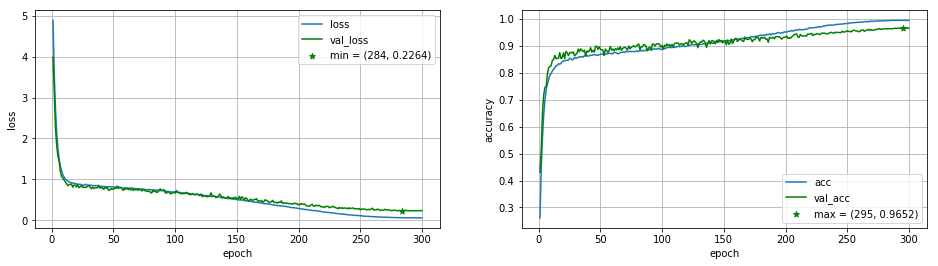

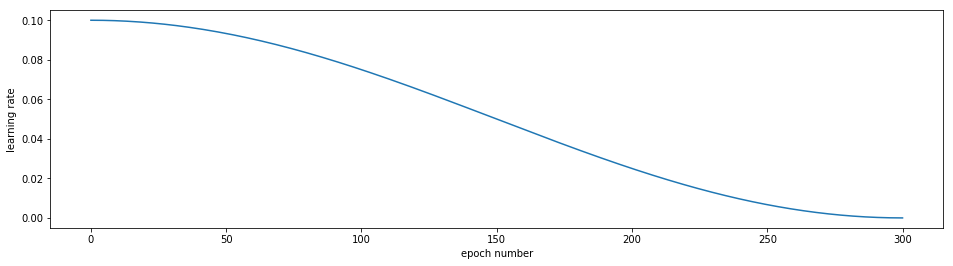

In [8]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [9]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_OneBitPerWeight_model_sReLU.h5')